In [1]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
def read_data(folder_path, raw_spotify_data = True):
    """this method either reads raw_spotify_data or reads the data extracted from it saved in csv format"""
    ls = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if raw_spotify_data:
            with open(file_path, 'r', encoding = 'utf-8') as f:

                    data = pd.read_json(file_path)
                    data = data.drop(columns = ['ts', 'platform', 'conn_country', 'ip_addr',
                                                'episode_name', 'audiobook_uri', 'audiobook_chapter_uri',
                                                'audiobook_chapter_title', 'reason_start', 'reason_end',
                                                'shuffle', 'offline', 'offline_timestamp', 'incognito_mode',
                                                'episode_show_name', 'spotify_episode_uri',	'audiobook_title', 'skipped'])

        else:
            data = pd.read_csv(file_path, encoding = "ISO-8859-1")
        ls.append(data)
    return ls

In [12]:
ID = ''
SECRET = ''
folder_path = r'C:\temp\Spotify_Wrapped\data_2025'

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id = ID,
                                               client_secret = SECRET))

spotify_data = read_data(folder_path)
df_q1 = spotify_data[0]
df_q1.head()

,ms_played,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri
0,164927,bye,Ariana Grande,eternal sunshine,spotify:track:1Rweq7vNjK4kZBbGrmxQsl
1,270258,Buzet e kuqe - A-Live-Night,Yll Limani,A live night with Yll Limani,spotify:track:0SZzw2mW37tzg7CYowICma
2,233226,(Nice Dream),Radiohead,The Bends,spotify:track:1tZcw7GtIqviL32bzaKdSo
3,207631,Nuk Jam Me,Elvana Gjata,Afër & Larg,spotify:track:4EhIEgrW0BZqO817mDkXeg
4,210000,Tfala Nga Prishtina,Etnon,Greatest Hits 1,spotify:track:7cmVYtBnSrhadEzcbbbGYs


### Clean & filter data


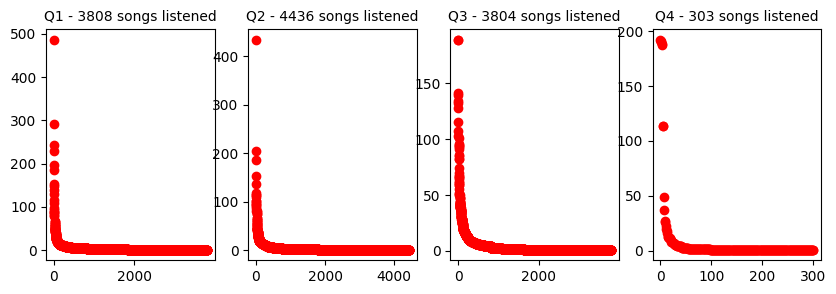

In [29]:
def get_total_tracks(df):
    """returns total number of songs listened"""
    return len(df['master_metadata_track_name'].unique())

def get_total_minutes(df):
    total_ms = df['ms_played'].sum()
    return total_ms / 60000

def get_total_albums(df):
    return len(df['master_metadata_album_album_name'].unique())

def get_total_artists(df):
    return len(df['master_metadata_album_artist_name'].unique())


fig, axs = plt.subplots(1,4, figsize = (10, 3))
for i in range(len(spotify_data)):
    total_listens = get_total_tracks(spotify_data[i])
    df = spotify_data[i]
    vals = list(df['master_metadata_track_name'].value_counts())
    axs[i].plot(vals, 'o', color = 'red')
    axs[i].set_title(f'Q{i + 1} - {total_listens} songs listened', fontsize = 10)
plt.show()

In [6]:
def filter_data(df, percentage = 0.25):
   """removes null vals & keeps only x percentile songs"""
   filtered = df[df['master_metadata_track_name'].notnull()]
   counts = df['master_metadata_track_name'].value_counts()
   cum_sum = counts.cumsum()
   total = counts.sum()
   songs = counts[cum_sum <= total * percentage]

   result = filtered[filtered['master_metadata_track_name'].isin(songs.index)]
   song_uris = result.groupby('master_metadata_track_name')['spotify_track_uri'].first().reset_index()
   # print(song_uris)
   songs.columns = ['master_metadata_track_name', 'play_count']

   songs = songs.to_frame()
   final_result = songs.merge(song_uris, on='master_metadata_track_name', how='left')
   genres = final_result['spotify_track_uri'].apply(get_song_genre)
   final_result['genre'] = genres

   return final_result


def get_song_genre(track_uri):
    """extracts genres from each track given"""
    track_id = track_uri.split(':')[-1]
    track = sp.track(track_id)
    artist_id = track['artists'][0]['id']
    artist_genre = sp.artist(artist_id)['genres']

    time.sleep(0.5)

    return artist_genre


##### Filter & extract

In [6]:
filtered_q1 = filter_data(spotify_data[0])

In [7]:
filtered_q1.to_csv('top_genres_11.csv', index = False)

In [52]:
filtered_q2 = filter_data(spotify_data[1])
filtered_q2.to_csv('top_genres_12.csv', index = False)

In [53]:
filtered_q3 = filter_data(spotify_data[2])
filtered_q3.to_csv('top_genres_13.csv', index = False)

In [54]:
filtered_q4 = filter_data(spotify_data[3])
filtered_q1.to_csv('top_genres_11.csv', index = False)

In [30]:
# get total number of songs listened for each quarter
total_listens = []
total_minutes = []
total_albums = []
total_artists = []

for i in range(len(spotify_data)):
    total_listens.append(get_total_tracks(spotify_data[i]))
    total_minutes.append(get_total_minutes(spotify_data[i]))
    total_albums.append(get_total_albums(spotify_data[i]))
    total_artists.append(get_total_artists(spotify_data[i]))
    
    

print(f"songs listened for each quarter: {total_listens}")

songs listened for each quarter: [3808, 4436, 3804, 303]


In [16]:
songs_listened = pd.DataFrame(total_listens)
songs_listened.to_csv('number_of_songs_listened.csv', index = False)

In [31]:
total_minutes = pd.DataFrame(total_minutes)
total_minutes.to_csv('total_minutes.csv', index = False)
total_albums = pd.DataFrame(total_albums)
total_albums.to_csv('total_albums.csv', index = False)
total_artists = pd.DataFrame(total_artists)
total_artists.to_csv('total_artists.csv', index = False)

In [25]:
get_total_albums(spotify_data[0])


2389

### Visualizing and analyzing


In [7]:
def primary_genre(genres):
    """choosing the broader genre for simplicity in grouping by genres"""
    if genres == "['alternative', 'indie']":
        return "['alternative']"
    else:
        return genres

def group_by_genre(df):
    """groups songs by genres"""
    new_df = df.groupby('genre', as_index = False).agg({
        'master_metadata_track_name': lambda x: ", ".join(x),
        'play_count': 'sum'
    }).sort_values(by='play_count', ascending=False).reset_index(drop=True)
    return new_df



##### Reading and analyzing genre preferences throughout the quarters


In [9]:
genres_path = r'C:\temp\Spotify_Wrapped\top_genres'
top_genres = read_data(genres_path, raw_spotify_data = False)

In [10]:
top_genres[2].head()

,master_metadata_track_name,play_count,spotify_track_uri,genre
0,11 Hz: Full Body Healing (Alpha Waves),189,spotify:track:3NPx7hDmtBehVQzNpWdoDI,healing sounds
1,11 Hz: Waves Instant Results (Alpha Waves),189,spotify:track:1K8bupD8llIBT0vqYr2OTE,healing sounds
2,House Tour,141,spotify:track:25jgQBxuUkGDdCG1WGKKN9,pop
3,Margaritar,140,spotify:track:5QTrNsrgp18AOaEGYJrr6E,folk pop
4,Zjerm,134,spotify:track:1MMfGAHowKNRithYDIRS1k,folktronica


In [11]:
group_genres_q1 = group_by_genre(top_genres[0]).sort_values(by='play_count', ascending = False)
group_genres_q2 = group_by_genre(top_genres[1]).sort_values(by='play_count', ascending = False)
group_genres_q3 = group_by_genre(top_genres[2]).sort_values(by='play_count', ascending = False)

In [12]:
group_genres_q1

,genre,master_metadata_track_name,play_count
0,pop,"bye, Knock 'Em Out, Juno, Pink Pony Club, twil...",772
1,folktronica,Zjerm,486
2,indie pop,"Bleed (feat. Omar Apollo), Up in the Air",390
3,hip hop,"Hey hey hey, Per Ty, Mos Shko",339
4,musicals,"The Winner Takes It All - From ""Mamma Mia!"", W...",314
5,soul pop,Messy,230
6,"nu disco, alternative dance",Fancy Footwork,186
7,bedroom pop,"Mrs Magic (Strings Version), Superglue",176
8,"art rock, alternative rock",(Nice Dream),153
9,alternative,"Not Strong Enough, Without You",144


In [13]:
def plot_top_genres(df, quarter):
    plt.figure(figsize = (10,5))
    df.plot(x = 'genre', y = 'play_count', kind = 'bar', color = 'red')
    plt.xticks(rotation = 45, ha = 'right')
    plt.title(f'Top 25th percentile genres of Quarter {quarter}')
    plt.ylabel('Play Count')
    plt.xlabel('Genres')
    plt.show()

<Figure size 1000x500 with 0 Axes>

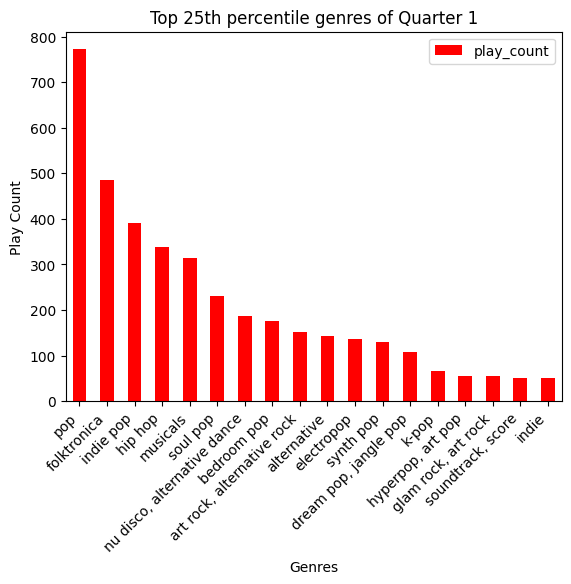

<Figure size 1000x500 with 0 Axes>

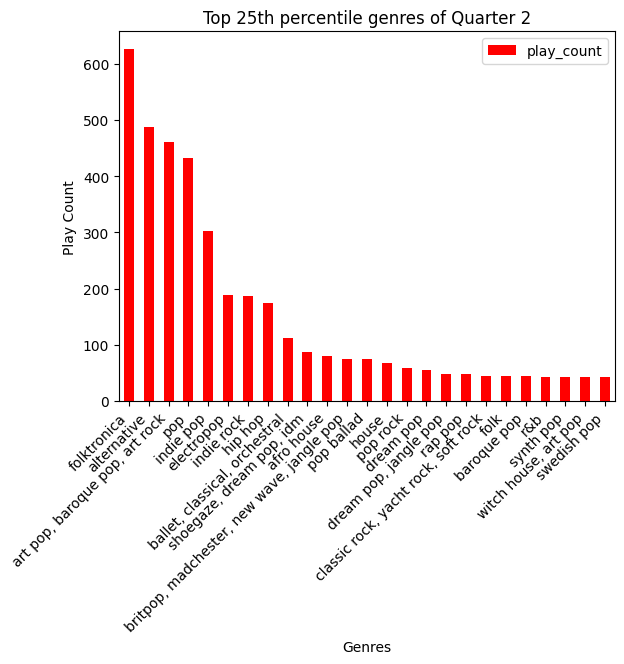

<Figure size 1000x500 with 0 Axes>

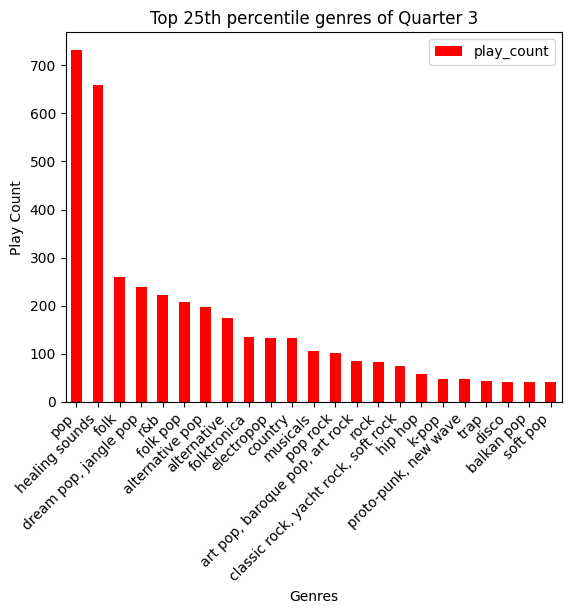

In [69]:
plot_top_genres(group_genres_q1, quarter = 1)
plot_top_genres(group_genres_q2, quarter = 2)
plot_top_genres(group_genres_q3, quarter = 3)

In [14]:
def get_proportions(df, song_count):
    """returns the percentage of each genre of a quarter"""
    new = df[['genre', 'play_count']]
    new['proportion'] = df['play_count'].div(song_count) * 100
    return new


In [16]:
proportions_q1 = get_proportions(group_genres_q1, song_count = total_listens[0])
proportions_q2 = get_proportions(group_genres_q2, song_count = total_listens[1])
proportions_q3 = get_proportions(group_genres_q3, song_count = total_listens[2])

In [17]:
# save proportions
proportions_q1.to_csv("proportions_q1.csv", index = False)
proportions_q2.to_csv("proportions_q2.csv", index = False)
proportions_q3.to_csv("proportions_q3.csv", index = False)

##### compare most popular genres throughout the quarters

In [53]:
def percentage_change(genre, Q1, Q2, Q3, total_listens):
    """param genre: genre you want to see
       param Q1, Q2, Q3: quarter dataframe proportions
       param list total_listens: total songs listened from each quarter"""

    percentage_changes = pd.DataFrame(columns = ['genre', 'Q1', 'Q2', 'Q3', 'change Q2 - Q1', 'change Q3 - Q2'])
    all_genres = set(proportions_q1['genre']) | set(proportions_q2['genre']) | set(proportions_q3['genre'])

    for genre in all_genres:

        if genre in Q1.values and genre in Q2.values and genre in Q3.values:
            proportion_q1 = proportions_q1.loc[proportions_q1['genre'] == genre, 'proportion'].values[0]
            proportion_q2 = proportions_q2.loc[proportions_q2['genre'] == genre, 'proportion'].values[0]
            proportion_q3 = proportions_q3.loc[proportions_q3['genre'] == genre, 'proportion'].values[0]

            change_q2_q1 = proportion_q2 - proportion_q1
            change_q3_q2 = proportion_q3 - proportion_q2
            percentage_changes.loc[len(percentage_changes)] = [genre, proportion_q1, proportion_q2, proportion_q3,change_q2_q1, change_q3_q2]

    return percentage_changes
    # return proportion_q2 - proportion_q1, proportion_q3 - proportion_q2


In [56]:
genre_changes = percentage_change('pop', proportions_q1, proportions_q2, proportions_q3, total_listens)


In [58]:
genre_changes.to_csv('genre_changes.csv', index = False)